In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
d = os.path.dirname(os.getcwd())
sys.path.insert(0, d)

In [2]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

import torch.nn as nn
import torch.nn.functional as F
from torch import optim

import torchvision
from torchvision.datasets import CIFAR10, MNIST
from torchvision.transforms import transforms

from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from utils.attacks import fgsm, pgd
from utils.utils import plot_images
from utils.train_utils import train, adv_train
from models.resnet import ResNet, SparseResNet
from models.wide_resnet import WideResNet, SparseWideResNet
from models.resnet_FReLU import FResNet, FSparseResNet

1.7.0
True


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [4]:
tr_transform = transforms.Compose([
#     transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
vl_transform = transforms.Compose([
    transforms.ToTensor()
])

ds = MNIST('../data', train=True, download=True, transform=tr_transform)
ds_test = MNIST('../data', train=False, download=True, transform=vl_transform)

batch_size = 400
train_dl = DataLoader(ds, batch_size, shuffle=True)
valid_dl = DataLoader(ds_test, batch_size, shuffle=True)

for X, y in valid_dl:
    X, y = X.to(device), y.to(device)
    break

In [5]:
import torch
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class FlattenReLU(torch.autograd.Function):
    @staticmethod
    def forward(self, x, thresholds=None):
        self.save_for_backward(x, thresholds)
        x = torch.where(x > thresholds, thresholds, x)
        x[x<0] = 0
        return x

    @staticmethod
    def backward(self, grad_output):
        x, thresholds = self.saved_tensors
        x_grad = grad_output.clone()
        x_grad[x>thresholds] = 0
        x_grad[x<0] = 0
        return x_grad, None

FRelu = FlattenReLU.apply

In [6]:
class ML(nn.Linear):

    def __init__(self, in_features, out_features, bias=False):
        super().__init__(in_features, out_features, bias)

    def forward(self, x):
        xe = torch.stack([x]*self.weight.size(0), dim=1)
        we = torch.stack([self.weight]*x.size(0), dim=0)
        z, _ = (we * xe).topk(int(0.1*self.weight.size(1)))
        thresholds = z.sum(dim=2)
        x = F.linear(x, self.weight, self.bias)
        return FRelu(x, thresholds)


In [7]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 10)
        
    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

Epoch: 1 Validation Loss: 0.4916 accuracy: 0.8337, time: 0:00:17                
Epoch: 2 Validation Loss: 0.4136 accuracy: 0.8526, time: 0:00:15                
Epoch: 3 Validation Loss: 0.3806 accuracy: 0.8615, time: 0:00:17                
Epoch: 4 Validation Loss: 0.1395 accuracy: 0.9577, time: 0:00:18                
Epoch: 5 Validation Loss: 0.1277 accuracy: 0.9610, time: 0:00:18                


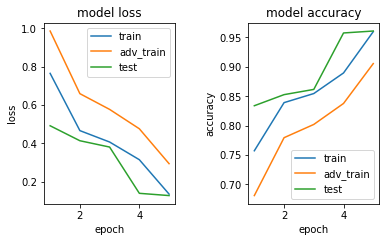

In [8]:
model = Net1().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-7, patience=2, verbose=True)

params = {
    "epsilon": 8/255,
    "alpha": 2/255,
    "num_iter": 10
}

adv_train(model, pgd, params, train_dl, valid_dl, loss_fn, optimizer, scheduler, epochs=5, device=device)

Epoch: 1 Validation Loss: 0.8580 accuracy: 0.7178, time: 0:00:23                
Epoch: 2 Validation Loss: 0.5640 accuracy: 0.8075, time: 0:00:24                
Epoch: 3 Validation Loss: 0.5312 accuracy: 0.8122, time: 0:00:23                
Epoch: 4 Validation Loss: 0.4949 accuracy: 0.8229, time: 0:00:22                
Epoch: 5 Validation Loss: 0.4871 accuracy: 0.8262, time: 0:00:23                
Epoch: 6 Validation Loss: 0.4878 accuracy: 0.8218, time: 0:00:24                
epochs_no_improve: 1/4
Epoch: 7 Validation Loss: 0.4582 accuracy: 0.8323, time: 0:00:23                
Epoch: 8 Validation Loss: 0.4510 accuracy: 0.8336, time: 0:00:25                
Epoch: 9 Validation Loss: 0.4588 accuracy: 0.8331, time: 0:00:22                
epochs_no_improve: 1/4
Epoch: 10 Validation Loss: 0.4534 accuracy: 0.8353, time: 0:00:22               
epochs_no_improve: 2/4


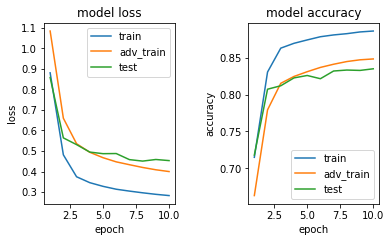

In [10]:
model = Net1().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-7, patience=2, verbose=True)

params = {
    "epsilon": 8/255,
    "alpha": 2/255,
    "num_iter": 10
}

adv_train(model, pgd, params, train_dl, valid_dl, loss_fn, optimizer, scheduler, epochs=10, device=device)

Epoch: 1 Validation Loss: 0.5433 accuracy: 0.8176, time: 0:00:14                
Epoch: 2 Validation Loss: 0.4450 accuracy: 0.8430, time: 0:00:13                
Epoch: 3 Validation Loss: 0.4042 accuracy: 0.8572, time: 0:00:14                
Epoch: 4 Validation Loss: 0.3812 accuracy: 0.8612, time: 0:00:14                
Epoch: 5 Validation Loss: 0.3787 accuracy: 0.8621, time: 0:00:13                


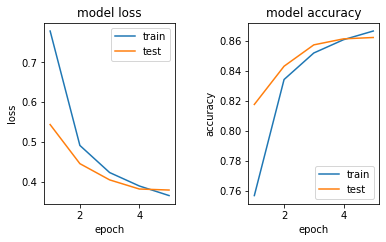

In [8]:
model = Net1().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-7, patience=2, verbose=True)

train(model, train_dl, valid_dl, loss_fn, optimizer, scheduler, epochs=5, device=device)

Epoch: 1 Validation Loss: 0.3281 accuracy: 0.9058, time: 0:00:19
Epoch: 2 Validation Loss: 0.2219 accuracy: 0.9336, time: 0:00:18
Epoch: 3 Validation Loss: 0.1740 accuracy: 0.9487, time: 0:00:19
Epoch: 4 Validation Loss: 0.1448 accuracy: 0.9572, time: 0:00:18
Epoch: 5 Validation Loss: 0.1396 accuracy: 0.9575, time: 0:00:17
Epoch: 6 Validation Loss: 0.1211 accuracy: 0.9631, time: 0:00:18
Epoch: 7 Validation Loss: 0.1204 accuracy: 0.9625, time: 0:00:18
Epoch: 8 Validation Loss: 0.1137 accuracy: 0.9646, time: 0:00:18
Epoch: 9 Validation Loss: 0.1119 accuracy: 0.9642, time: 0:00:18
Epoch: 10 Validation Loss: 0.1068 accuracy: 0.9659, time: 0:00:17


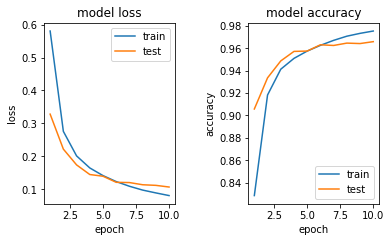

In [9]:
model = Net1().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-7, patience=2, verbose=True)

train(model, train_dl, valid_dl, loss_fn, optimizer, scheduler, epochs=10, device=device)

In [11]:
import torch
import torch.nn as nn

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

class FlattenReLU(torch.autograd.Function):
    @staticmethod
    def forward(self, x, thresholds):
        self.save_for_backward(x, thresholds)
        x = torch.where(x > thresholds, thresholds, x)
        x[x<0] = 0
        return x

    @staticmethod
    def backward(self, grad_output):
        x, thresholds = self.saved_tensors
        x_grad = grad_output.clone()
        x_grad[x>thresholds] = 0
        x_grad[x<0] = 0
        return x_grad, None

FRelu = FlattenReLU.apply

class myLinear(nn.Linear):

    def __init__(self, in_features, out_features, bias=False):
        super().__init__(in_features, out_features, bias)

    def forward(self, x):
        xe = torch.stack([x]*self.weight.size(0), dim=1)
        we = torch.stack([self.weight]*x.size(0), dim=0)
        z, _ = (we * xe).topk(int(0.3*self.weight.size(1)))
        thresholds = z.sum(dim=2)
        x = F.linear(x, self.weight, self.bias)    
        return FRelu(x, thresholds)


In [12]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = myLinear(10, 2, bias=False)
        
    def forward(self, x):
        x = self.fc1(x)
        return x

model = Net()
model

Net(
  (fc1): myLinear(in_features=10, out_features=2, bias=False)
)

In [13]:
w = model.fc1.weight.clone()
w = torch.Tensor([[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1], 
                  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
                 ])
x = torch.Tensor([[1,2,3,4,5,6,7,8,9,10], [10,9,-8,-7,-6,-5,4,3,2,1], [6,7,8,9,10,5,4,3,2,1]])
model.fc1.weight.data = w
print(model.fc1.weight.data)
print(x)

tensor([[1.0000, 0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000, 0.3000, 0.2000,
         0.1000],
        [0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
         1.0000]])
tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
        [10.,  9., -8., -7., -6., -5.,  4.,  3.,  2.,  1.],
        [ 6.,  7.,  8.,  9., 10.,  5.,  4.,  3.,  2.,  1.]])


In [14]:
xe = torch.stack([x]*w.size(0), dim=1)
xe

tensor([[[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.],
         [ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]],

        [[10.,  9., -8., -7., -6., -5.,  4.,  3.,  2.,  1.],
         [10.,  9., -8., -7., -6., -5.,  4.,  3.,  2.,  1.]],

        [[ 6.,  7.,  8.,  9., 10.,  5.,  4.,  3.,  2.,  1.],
         [ 6.,  7.,  8.,  9., 10.,  5.,  4.,  3.,  2.,  1.]]])

In [35]:
we = torch.stack([w]*x.size(0), dim=0)
we

tensor([[[1.0000, 0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000, 0.3000,
          0.2000, 0.1000],
         [0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
          0.9000, 1.0000]],

        [[1.0000, 0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000, 0.3000,
          0.2000, 0.1000],
         [0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
          0.9000, 1.0000]],

        [[1.0000, 0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000, 0.3000,
          0.2000, 0.1000],
         [0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
          0.9000, 1.0000]]])

In [563]:
(we * xe)

tensor([[[ 1.0000,  1.8000,  2.4000,  2.8000,  3.0000,  3.0000,  2.8000,
           2.4000,  1.8000,  1.0000],
         [ 0.1000,  0.4000,  0.9000,  1.6000,  2.5000,  3.6000,  4.9000,
           6.4000,  8.1000, 10.0000]],

        [[10.0000,  8.1000, -6.4000, -4.9000, -3.6000, -2.5000,  1.6000,
           0.9000,  0.4000,  0.1000],
         [ 1.0000,  1.8000, -2.4000, -2.8000, -3.0000, -3.0000,  2.8000,
           2.4000,  1.8000,  1.0000]],

        [[ 6.0000,  6.3000,  6.4000,  6.3000,  6.0000,  2.5000,  1.6000,
           0.9000,  0.4000,  0.1000],
         [ 0.6000,  1.4000,  2.4000,  3.6000,  5.0000,  3.0000,  2.8000,
           2.4000,  1.8000,  1.0000]]])

In [570]:
val, _ = (we * xe).topk(int(0.3*w.size(1)))
print(val)

tensor([[[ 3.0000,  3.0000,  2.8000],
         [10.0000,  8.1000,  6.4000]],

        [[10.0000,  8.1000,  1.6000],
         [ 2.8000,  2.4000,  1.8000]],

        [[ 6.4000,  6.3000,  6.3000],
         [ 5.0000,  3.6000,  3.0000]]])


In [571]:
thresholds = val.sum(dim=-1)
print(thresholds)

tensor([[ 8.8000, 24.5000],
        [19.7000,  7.0000],
        [19.0000, 11.6000]])


In [572]:
res = x @ w.T
f = torch.where(res > thresholds, thresholds, res)
f[f<0]=0
f

tensor([[ 8.8000, 24.5000],
        [ 3.7000,  0.0000],
        [19.0000, 11.6000]])

In [573]:
model(x)

tensor([[ 8.8000, 24.5000],
        [ 3.7000,  0.0000],
        [19.0000, 11.6000]], grad_fn=<FlattenReLUBackward>)

In [574]:
x @ w.T

tensor([[22.0000, 38.5000],
        [ 3.7000, -0.4000],
        [36.5000, 24.0000]])